In [3]:
# import modules 
% matplotlib inline

import os
import pylab
import random
import pandas as pd
import numpy as np
import cPickle as pkl
from scipy.io import loadmat
from lasagne import layers, updates
from scipy.misc import imread, imresize
from lasagne.nonlinearities import softmax
from nolearn.lasagne import NeuralNet, BatchIterator

svt_data_root = 'SVT-CHAR/svt-word'
svt_char_root = 'SVT-CHAR/testCharBound.mat'
project_root = 'workspace/.project/project'
data_root = os.path.join(os.path.expanduser('~'), project_root, 'datasets')
model_root = os.path.join(os.path.expanduser('~'), project_root, 'models')

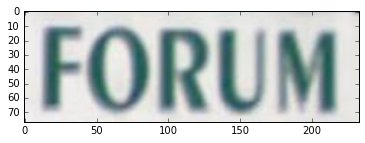

In [4]:
img = imread(os.path.join(data_root, svt_data_root, '00_02_1.png'))
pylab.imshow(img)

In [5]:
labelsInfo = loadmat(os.path.join(data_root, svt_char_root), squeeze_me = True, struct_as_record = False)

In [6]:
x, y, w, h = labelsInfo['testCharBound'][0].charBB[0]

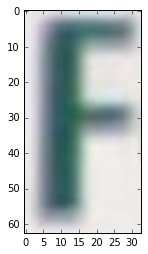

In [7]:
pylab.imshow(img[x:x+h, y:y+w])

In [11]:
labelsInfo['testCharBound'][0].charBB.shape[0]

5

In [22]:
# make data_x and y
#y = np.zeros(())

In [ ]:
def build_model(input_width, input_height, output_dim,
                batch_size=BATCH_SIZE):
    ini = lasagne.init.HeUniform()
    l_in = lasagne.layers.InputLayer(shape=(None, 1, input_width, input_height),)

    # Localization network
    b = np.zeros((2, 3), dtype=theano.config.floatX)
    b[0, 0] = 1
    b[1, 1] = 1
    b = b.flatten()
    loc_l1 = pool(l_in, pool_size=(2, 2))
    loc_l2 = conv(
        loc_l1, num_filters=20, filter_size=(5, 5), W=ini)
    loc_l3 = pool(loc_l2, pool_size=(2, 2))
    loc_l4 = conv(loc_l3, num_filters=20, filter_size=(5, 5), W=ini)
    loc_l5 = lasagne.layers.DenseLayer(
        loc_l4, num_units=50, W=lasagne.init.HeUniform('relu'))
    loc_out = lasagne.layers.DenseLayer(
        loc_l5, num_units=6, b=b, W=lasagne.init.Constant(0.0), 
        nonlinearity=lasagne.nonlinearities.identity)
    
    # Transformer network
    l_trans1 = lasagne.layers.TransformerLayer(l_in, loc_out, downsample_factor=3.0)
    print "Transformer network output shape: ", l_trans1.output_shape
    
    # Classification network
    class_l1 = conv(
        l_trans1,
        num_filters=32,
        filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )
    class_l2 = pool(class_l1, pool_size=(2, 2))
    class_l3 = conv(
        class_l2,
        num_filters=32,
        filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )
    class_l4 = pool(class_l3, pool_size=(2, 2))
    class_l5 = lasagne.layers.DenseLayer(
        class_l4,
        num_units=256,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )

    l_out = lasagne.layers.DenseLayer(
        class_l5,
        num_units=output_dim,
        nonlinearity=lasagne.nonlinearities.softmax,
        W=ini,
    )

    return l_out

model = build_model(32, 32, 62)